In [5]:
import gdown
import os

output_file = "Checkpoints/checkpoints_for_test.pth" 
url = "https://drive.google.com/drive/folders/1hP2gGGow72tTQzKIgeM1ZMK4vSKYsgrp?usp=drive_link"

if not os.path.exists(output_file):
    os.makedirs("Checkpoints")
    print("File doesn't exist. Downloading...")
    gdown.download(url, output_file, quiet=False)
    print("Download completed.")
else:
    print("File already exists.")

File already exists.


/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


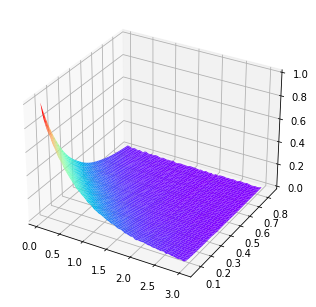

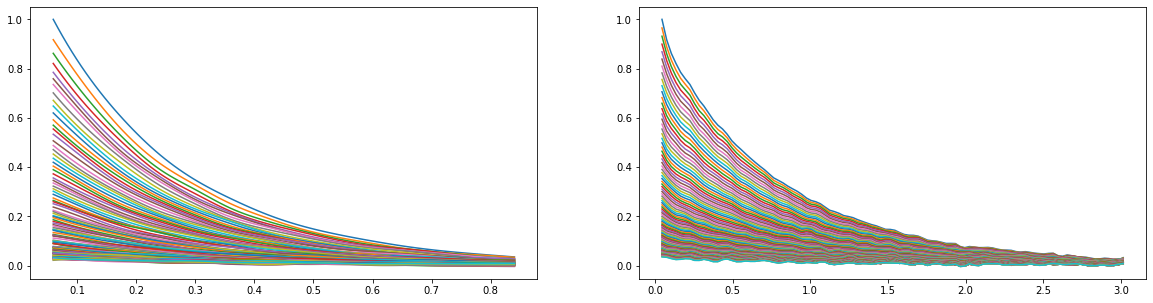

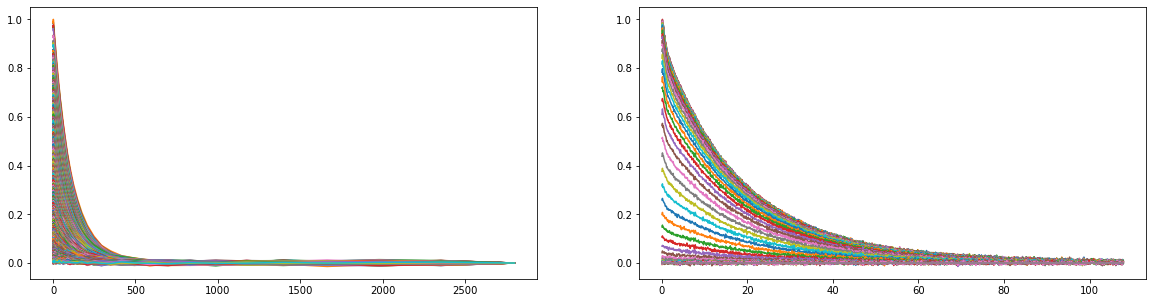

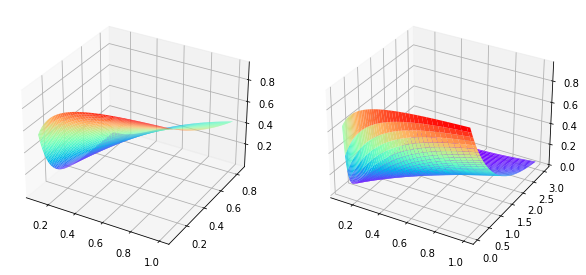

In [2]:
import scipy.io as scio
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_new_decay(decay_data, b, t, max_ending):
    decay_dim = 100
    decay_data = decay_data / decay_data[0, 0]

    max_row = np.max(decay_data, axis=1)
    max_col = np.max(decay_data, axis=0)
    row_position = np.where(max_row > max_ending)
    col_position = np.where(max_col > max_ending)
    new_b = b[row_position]
    new_t = t[col_position]

    new_t = np.linspace(np.min(new_t), np.max(new_t), decay_dim)
    new_b = np.linspace(np.min(new_b), np.max(new_b), decay_dim)

    interp_func = interp2d(t, b, decay_data, kind='cubic')
    decay_data = interp_func(new_t, new_b)
    decay_data = decay_data / decay_data[0, 0]

    range_D = np.logspace(-1, 0, 100)
    range_T = np.logspace(-1, 0, 100)
    KD = np.exp(-np.dot(new_b[:, np.newaxis], 1 / range_D[np.newaxis, :]))
    KT = np.exp(-np.dot(new_t[:, np.newaxis], 1 / range_T[np.newaxis, :]))

    concat_data = np.concatenate([KD[np.newaxis, :, :], decay_data[np.newaxis, :, :], KT[np.newaxis, :, :]])

    return decay_data, concat_data, new_b, new_t, range_D, range_T

def data_pre_process(ori_decay, ori_b, ori_t, scale_b, scale_t, max_ending):
    x_new = np.linspace(np.min(ori_t), np.max(ori_t), 100)
    y_new = np.linspace(np.min(ori_b), np.max(ori_b), 100)

    interp_func = interp2d(ori_t, ori_b, ori_decay, kind='cubic')
    interp_decay = interp_func(x_new, y_new)

    x_new = np.linspace(0.05, 5, 100) * scale_t
    y_new = np.linspace(0.05, 5, 100) * scale_b
    new_decay, concat_data, y_new, x_new, range_D, range_T = get_new_decay(interp_decay, y_new, x_new, max_ending)

    return new_decay, concat_data, y_new, x_new, range_D, range_T

ori_data = scio.loadmat('Dataset/T1T2_net_input.mat')
b = ori_data['b'].T
t = ori_data['t'].T
ori_s = ori_data['S']

scale_b = 1.2
scale_t = 0.9
new_decay, concat_data, y_new, x_new, range_D, range_T = data_pre_process(ori_s, b, t, scale_b=scale_b, scale_t=scale_t, max_ending=0.03)
result_scale_D = np.max(b) / (scale_b * 5)
result_scale_T = np.max(t) / (scale_t * 5)

figure = plt.figure(1)
axes = Axes3D(figure)
X = x_new
Y = y_new
X,Y = np.meshgrid(X, Y)
Z = new_decay
axes.plot_surface(X,Y,Z,cmap='rainbow')

plt.figure(2, figsize=[20, 5])
plt.subplot(1, 2, 1)
plt.plot(y_new.T, new_decay)
plt.subplot(1, 2, 2)
plt.plot(x_new.T, new_decay.T)

plt.figure(3, figsize=[20, 5])
plt.subplot(1, 2, 1)
plt.plot(b.T, ori_s)
plt.subplot(1, 2, 2)
plt.plot(t.T, ori_s.T)

figure = plt.figure(4, figsize=[10, 5])
axes1 = figure.add_subplot(121, projection='3d')
axes2 = figure.add_subplot(122, projection='3d')
X, Y = np.meshgrid(range_D, y_new)
Z = concat_data[0, :, :]
axes1.plot_surface(X, Y, Z, cmap='rainbow')
X, Y = np.meshgrid(range_T, x_new)
Z = concat_data[2, :, :]
axes2.plot_surface(X, Y, Z, cmap='rainbow')

In [11]:
import torch
import train

epoch = 300

with torch.no_grad():
    DEVICE = torch.device('cuda:0')
    checkpoint = torch.load('Checkpoints/checkpoints_for_test.pth', map_location='cuda:0')
    args = checkpoint['args']
    module = train.set_module(args)
    module.load_state_dict(checkpoint['model'])
    module.to(DEVICE)
    module.eval()

test_input = torch.tensor(concat_data).unsqueeze(0).to(DEVICE)
test_input = test_input.to(torch.float32)

test_out = module(test_input)
test_out = test_out.cpu().detach().numpy()

/tmp/ipykernel_7071/1799497683.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure)


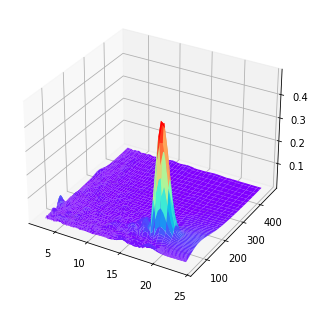

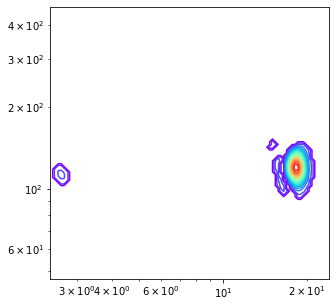

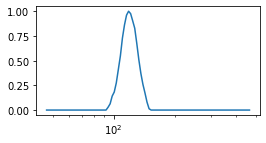

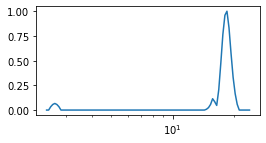

In [12]:
label_dim = 100

figure = plt.figure(0)
axes = Axes3D(figure)

x = np.logspace(-1, 0, 100)*result_scale_T
y = np.logspace(-1, 0, 100)*result_scale_D

X,Y = np.meshgrid(x, y)
Z = test_out[0].reshape(label_dim, label_dim)
axes.plot_surface(X,Y,Z,cmap='rainbow')
plt.show()

Z[Z<0.04]=0
plt.figure(1, figsize=(5, 5))
plt.contour(X, Y, Z, 20, cmap='rainbow')
plt.xscale('log')
plt.yscale('log')
plt.show()

Z = Z / np.max(Z)
plt.figure(1, figsize=(4, 2))
plt.plot(y, np.sum(Z, axis=1).T / np.max(np.sum(Z, axis=1)))
plt.xscale('log')
plt.figure(2, figsize=(4, 2))
plt.plot(x, np.sum(Z, axis=0).T / np.max(np.sum(Z, axis=0)))
plt.xscale('log')